In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [6]:
%matplotlib notebook

In [7]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [8]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\psth'

<IPython.core.display.Javascript object>


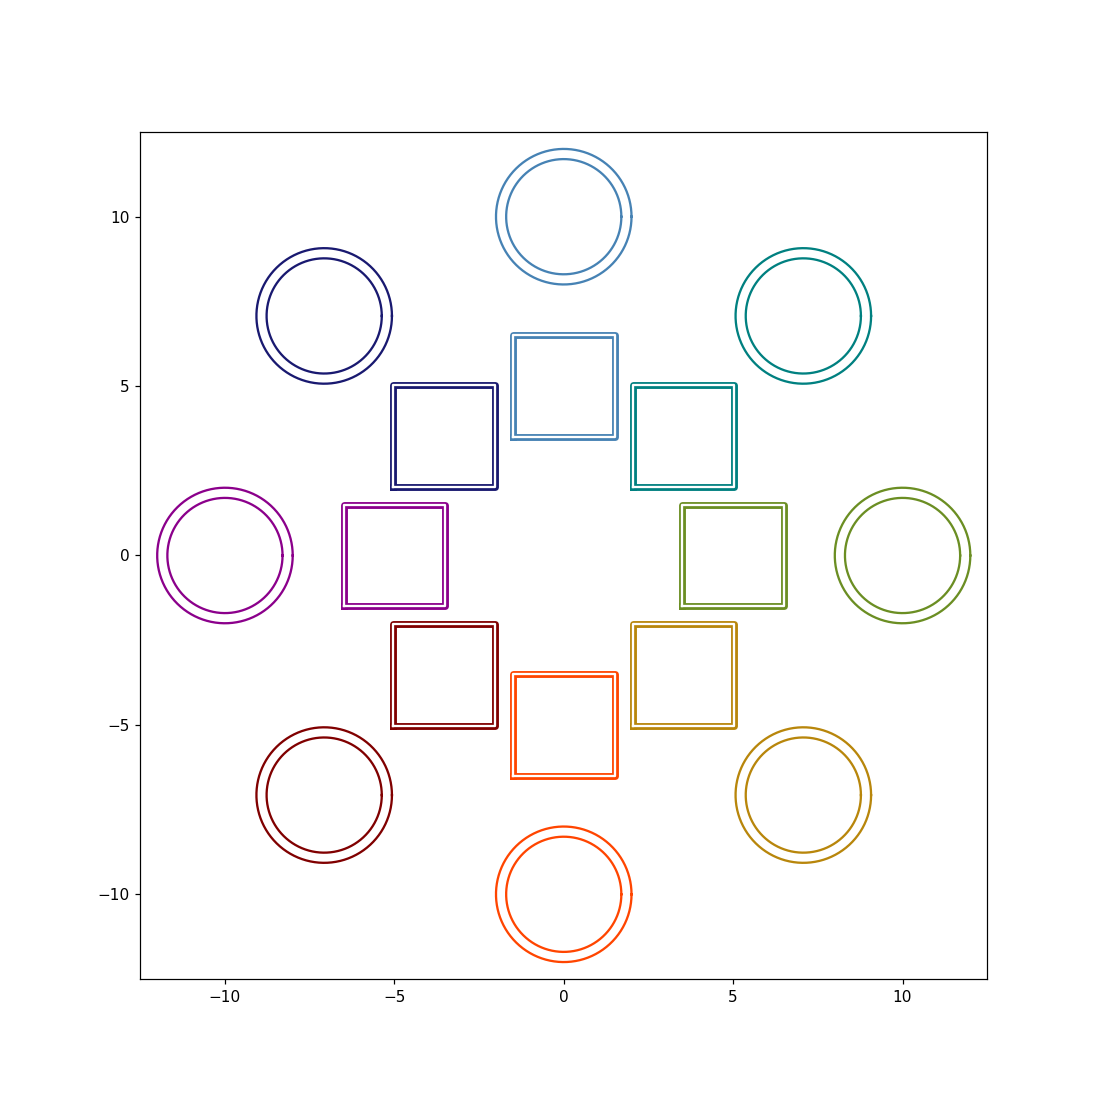

In [9]:
#Plot the targets and obstacles: 
plot_task = True

plot_target = True
plot_obs_big = True
plot_obs_small = False

save_bool = True
plt_ext = ['.eps']

if plot_task:
    plot = {}
    plot['size'] = (10,10)
    plot['xlim'] = (-12.5,12.5)
    plot['ylim'] = (-12.5,12.5)

    plt.figure(figsize=plot['size'])

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        for task in range(num_tasks):
            bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))                
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    if save_bool: 
        plt_name = 'target_obstacle'
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))

In [ ]:
target_r_eff

In [ ]:
target_r_task


In [ ]:
cursor_r

In [ ]:
target_r_eff = copy.copy(target_r_task)
target_r_eff[0] += cursor_r[0]
target_r_eff[1] += cursor_r[1]

In [ ]:
target_r_task

<IPython.core.display.Javascript object>


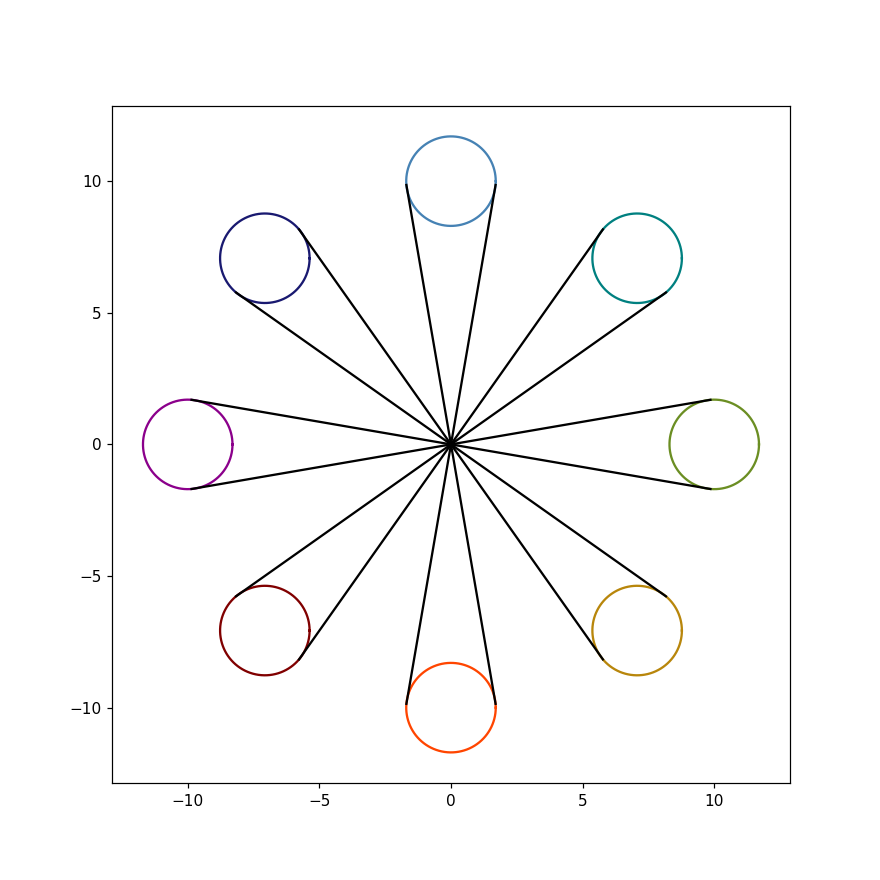

9.752049739225924


In [10]:
#Confirm the angles the cursor can use to hit the target
r=10

#the intersection of: x^2+(y-10)^2=1.7^2, x^2+y^2=100.  solved for using wolfram alpha.
x_sol = 17*(39711)**(0.5)/2000.0
y_sol = 19711.0/2000.0

theta_max = np.arctan2(x_sol, y_sol)
plt.figure(figsize=(8,8))
bmi_util.plot_targets(target_pos, target_color, target_r_task[0]*np.ones(num_targets)) 
for target in range(num_targets):
    mult_list = [1,-1]
    for mult in mult_list:
        theta = target_angle[target]+theta_max*mult
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        plt.plot(np.array([0, x]), np.array([0, y]), 'k')
plt.axis('square')
print(theta_max*180/np.pi)

In [ ]:
obs_big

angle to avoid obstacle:
23.19859051364819


<IPython.core.display.Javascript object>


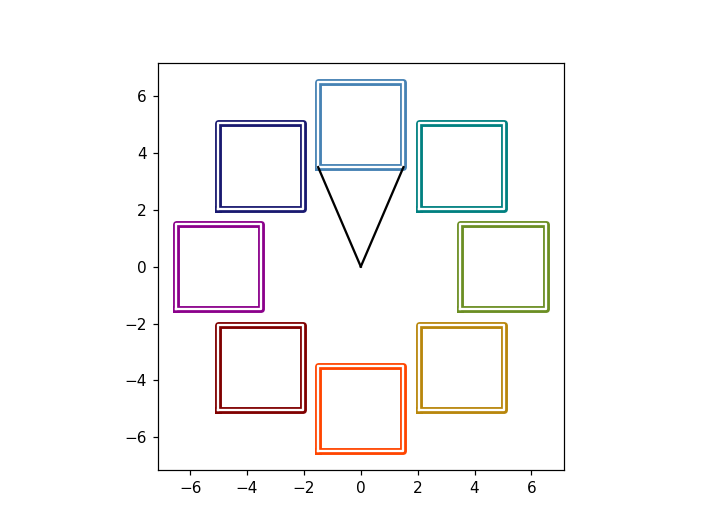

(-7.15, 7.15, -7.15, 7.15)

In [11]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0
obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

plt.figure()
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
x= np.array([0, obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
x= np.array([0, -obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
plt.axis('square')

In [12]:
#angle for avoiding obstacle in diagonal positions: 
obs_y = 5
obs_x = ((obs_big**2+obs_big**2)**0.5)/2
obs_theta_diag = np.arctan2(obs_x, obs_y)
print(obs_theta_diag*180/np.pi)

22.98976777360885


angle to avoid obstacle:
23.19859051364819


<IPython.core.display.Javascript object>


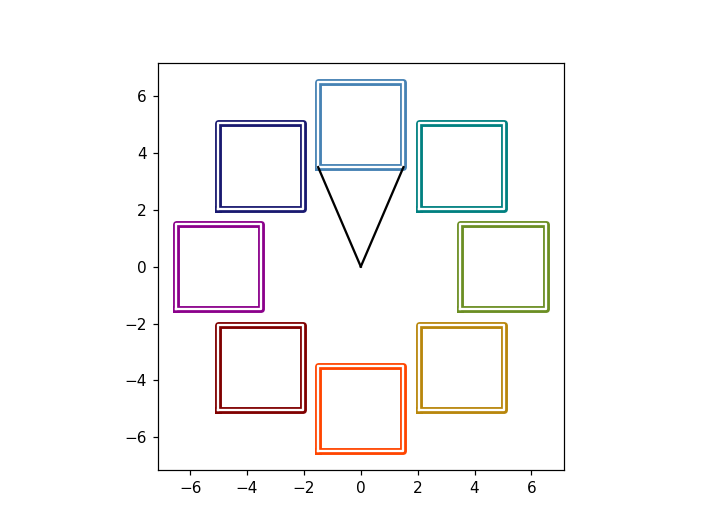

(-7.15, 7.15, -7.15, 7.15)

In [13]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0
obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

plt.figure()
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
x= np.array([0, obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
x= np.array([0, -obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
plt.axis('square')

<IPython.core.display.Javascript object>


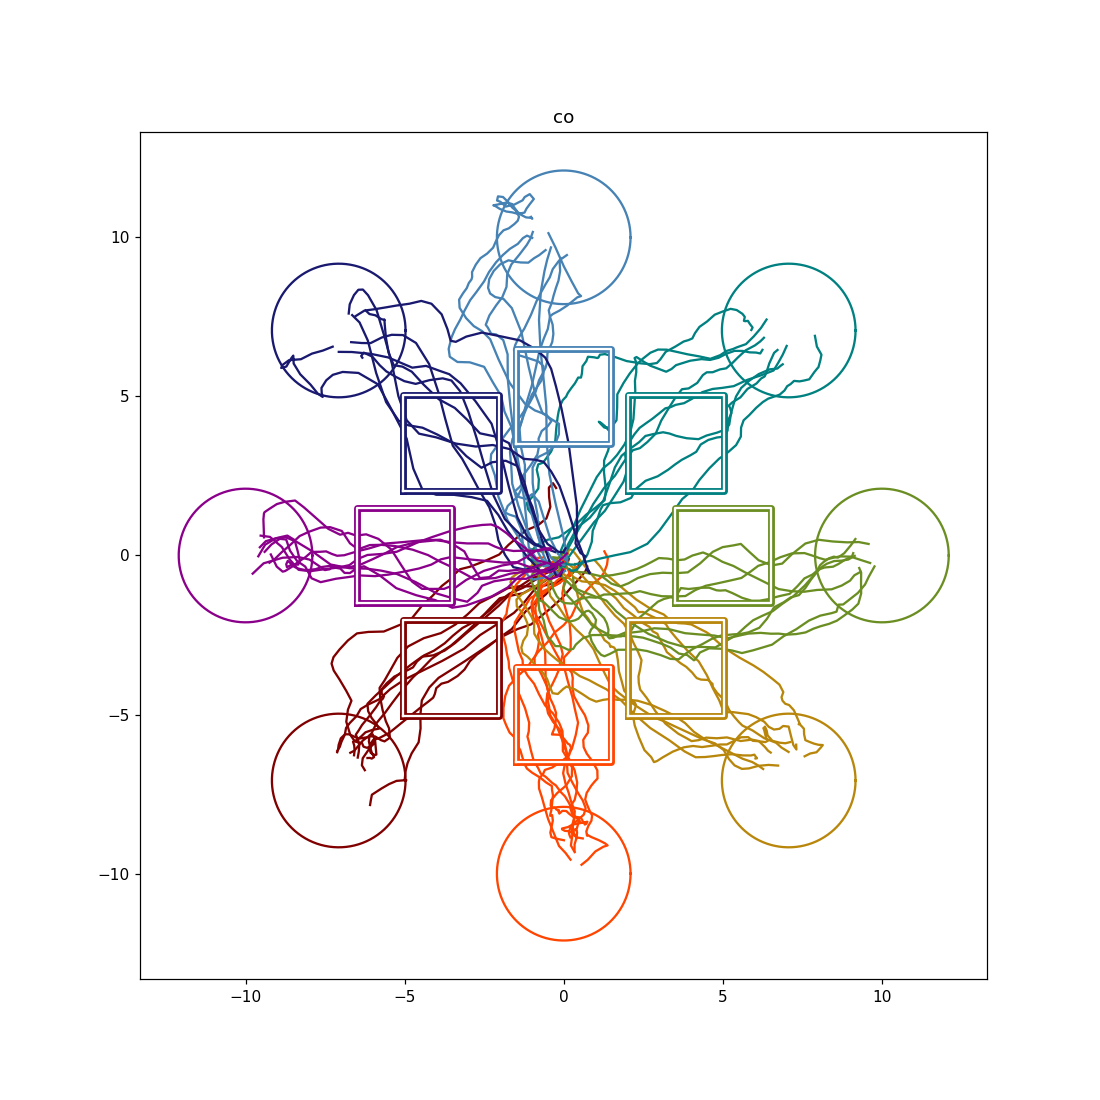

<IPython.core.display.Javascript object>


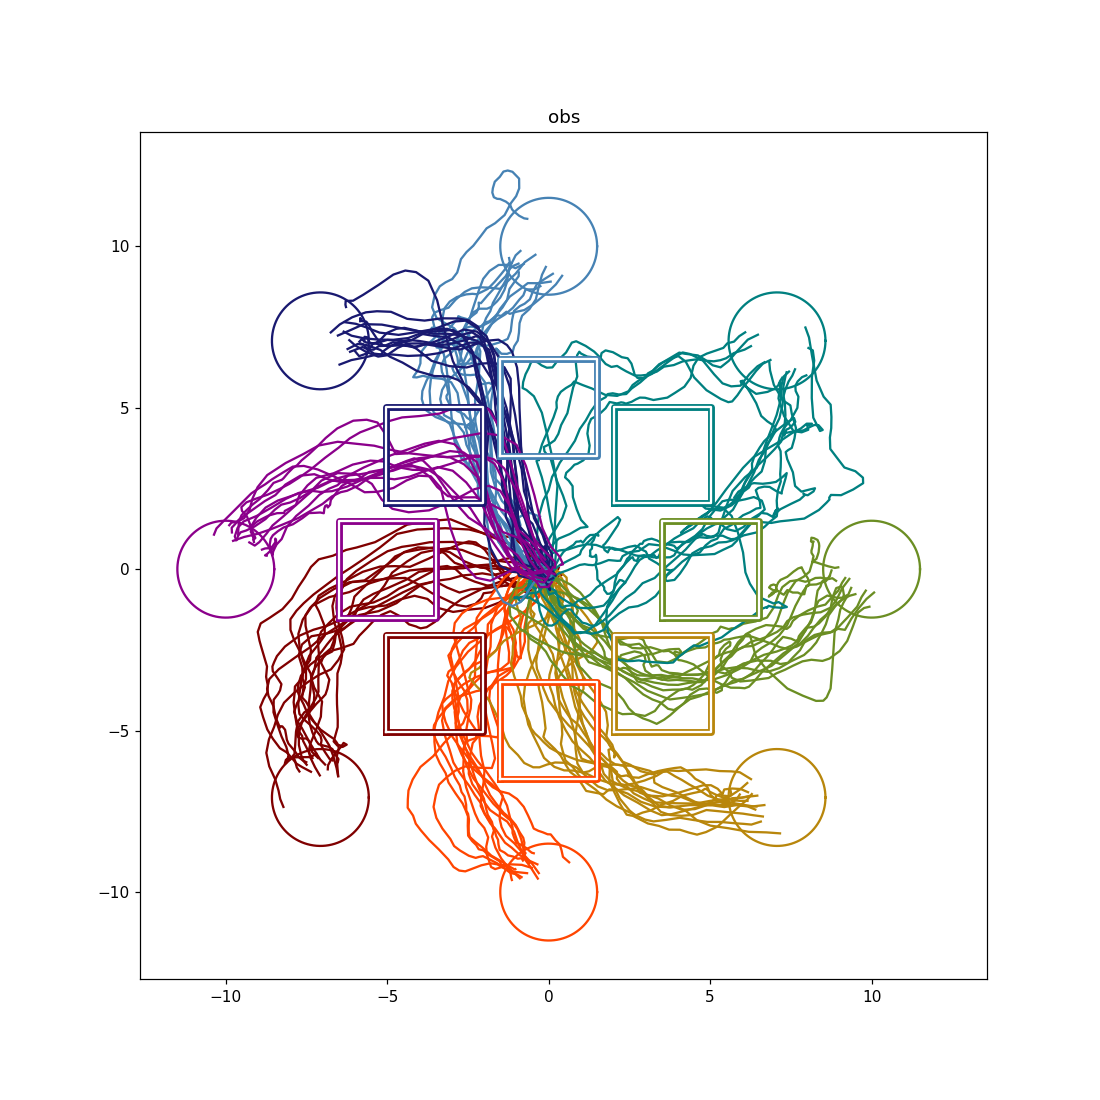

In [14]:
#PLOT INDIVIDUAL TRIALS: 
save_bool = True
plt_prefix = 'trials'
plt_ext = ['.png', '.eps']

plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

plot_obs_subset = True
plot_obs_small_trials = False
plot_obs_big_trials = True


plot_target = True
plot_obs_small = False
plot_obs_big = True

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        if task_str == 'co' or (task_str == 'obs' and plot_obs_subset == False): 
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        elif task_str == 'obs' and plot_obs_small_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_small)
        elif task_str == 'obs' and plot_obs_big_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_big)
             
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()
    
    if save_bool: 
        plt_name = plt_prefix + '_' + task_str
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    
    

In [ ]:
df.columns

In [ ]:
df.shape

In [15]:
#Identify if each trajectory is more clockwise or counterclockwise around the axis from center to target: 

df['cw'] = np.zeros((df.shape[0])) #cw = positive signed area
df['target_axis_signed_area'] = np.zeros((df.shape[0]))
df['target_axis_area'] = np.zeros((df.shape[0]))

trial_start = np.where((df['trial_start']==1))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

a_dic = {('a','co'):[], ('a','obs'):[], ('sa','co'):[], ('sa','obs'):[]}

for bnd in trial_bound: 
#     print(bnd)
#     x = df.loc[bnd[0]:bnd[1], 'kin_px']
#     y = df.loc[bnd[0]:bnd[1], 'kin_py']
    x = df['kin_px'][bnd[0]:bnd[1]+1]
    y = df['kin_py'][bnd[0]:bnd[1]+1]
    t = int(df['target'][bnd[0]])
    t_pos = target_pos[t,:]
    sa, a, df_a = bmi_b.traj_signed_area_about_target_axis(x, y, t_pos)
    if sa>0:
        cw=1
    else:
        cw=0
    
    #debug: 
    tsk = task_list[int(df['task'][bnd[0]])]
    trl = df['trial'][bnd[0]]
    trl_len = bnd[1]+1-bnd[0]
    print(bnd[0], bnd[1], trl_len, tsk, t, trl, sa, cw, a)
    #Insert the data: 
    df['target_axis_signed_area'][bnd[0]:bnd[1]+1] = sa
    df['cw'][bnd[0]:bnd[1]+1] = cw
    df['target_axis_area'][bnd[0]:bnd[1]+1] = a
    
    #collect for stats: 
    a_dic[('a',tsk)].append(a/trl_len)
    a_dic[('sa',tsk)].append(sa/trl_len)
    

(0, 49, 50, 'co', 0, 0.0, -19.251960635384332, 0, 19.644750186196656)
(50, 94, 45, 'co', 0, 12.0, 2.128124174260119, 1, 2.4144401793970927)
(95, 126, 32, 'co', 0, 16.0, -5.764454822835146, 0, 7.068116685350529)
(127, 157, 31, 'co', 0, 24.0, -3.892708659387396, 0, 4.301092381935767)
(158, 179, 22, 'co', 0, 38.0, -3.8760269539053556, 0, 4.423813202685366)
(180, 210, 31, 'co', 0, 46.0, -5.261601422632328, 0, 5.261601422632328)
(211, 242, 32, 'co', 0, 51.0, -4.947140325206385, 0, 5.055331520905332)
(243, 273, 31, 'co', 0, 56.0, 6.481953721177707, 1, 6.717038232358442)
(274, 319, 46, 'co', 1, 1.0, -5.444897714094759, 0, 8.81043740920863)
(320, 371, 52, 'co', 1, 14.0, 3.079872695967537, 1, 6.023246296083505)
(372, 400, 29, 'co', 1, 21.0, 1.7057096517474548, 1, 1.7444137909390849)
(401, 462, 62, 'co', 1, 31.0, -4.324886797356999, 0, 5.51354777473145)
(463, 504, 42, 'co', 1, 34.0, -9.398350794596556, 0, 10.174426290934015)
(505, 553, 49, 'co', 1, 42.0, -4.5125572970621555, 0, 4.817209567737263

(5122, 5159, 38, 'obs', 4, 69.0, 16.96710252201651, 1, 16.96710252201651)
(5160, 5224, 65, 'obs', 4, 74.0, -21.984920722993877, 0, 29.551155155865562)
(5225, 5322, 98, 'obs', 4, 89.0, -17.463634182832152, 0, 19.93090970667572)
(5323, 5391, 69, 'obs', 4, 90.0, -29.46083803617832, 0, 33.91125796949944)
(5392, 5459, 68, 'obs', 4, 98.0, 14.96918058054075, 1, 16.749686924997484)
(5460, 5514, 55, 'obs', 5, 0.0, 20.44200275342639, 1, 25.865882301085858)
(5515, 5549, 35, 'obs', 5, 12.0, 10.448681571787322, 1, 10.792818742036138)
(5550, 5598, 49, 'obs', 5, 18.0, 21.799410377370144, 1, 24.48340524447923)
(5599, 5631, 33, 'obs', 5, 21.0, 14.803334033318633, 1, 14.803334033318633)
(5632, 5670, 39, 'obs', 5, 34.0, 11.605307685704421, 1, 13.340458058296694)
(5671, 5710, 40, 'obs', 5, 41.0, 12.547869415754397, 1, 13.060299797211176)
(5711, 5738, 28, 'obs', 5, 59.0, 12.182886938333624, 1, 12.380910261295895)
(5739, 5777, 39, 'obs', 5, 62.0, 15.485672929230969, 1, 16.15511038650707)
(5778, 5823, 46, 'o

(10921, 10955, 35, 'obs', 5, 78.0, 15.030639934365793, 1, 15.472455252593436)
(10956, 10987, 32, 'obs', 5, 82.0, 20.91271131183929, 1, 22.23278931950039)
(10988, 11021, 34, 'obs', 5, 92.0, 11.388627913201951, 1, 11.542231065873828)
(11022, 11054, 33, 'obs', 5, 102.0, 23.15902818602772, 1, 23.376103133294677)
(11055, 11083, 29, 'obs', 5, 111.0, 18.042136161119192, 1, 18.042136161119192)
(11084, 11114, 31, 'obs', 5, 119.0, 11.90989569989568, 1, 13.675299998739328)
(11115, 11139, 25, 'obs', 6, 1.0, -20.19313329529047, 0, 20.19313329529047)
(11140, 11163, 24, 'obs', 6, 6.0, -15.373275131811749, 0, 15.819463621189435)
(11164, 11188, 25, 'obs', 6, 16.0, -16.811826833334187, 0, 17.263222763997735)
(11189, 11213, 25, 'obs', 6, 31.0, -16.28023096697492, 0, 16.28208503780583)
(11214, 11234, 21, 'obs', 6, 32.0, -16.096132238390773, 0, 16.61212198809829)
(11235, 11260, 26, 'obs', 6, 42.0, -9.464805819404171, 0, 13.1615706469408)
(11261, 11290, 30, 'obs', 6, 60.0, -17.17559210895872, 0, 17.44123267

<IPython.core.display.Javascript object>


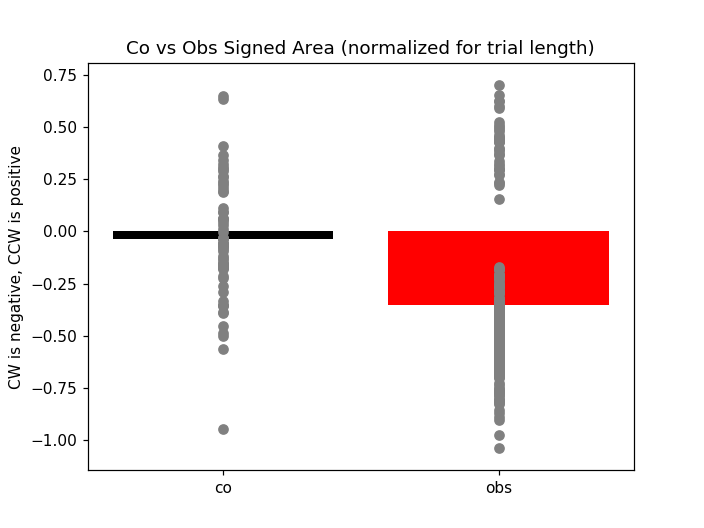

<IPython.core.display.Javascript object>


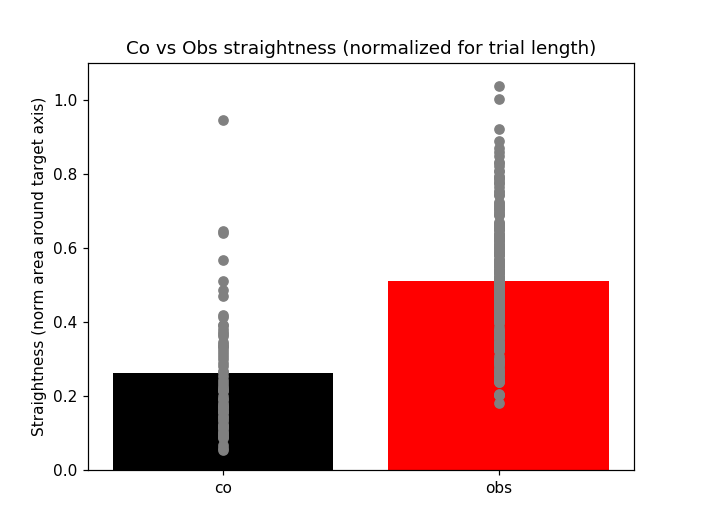

([<matplotlib.axis.XTick at 0x4429aec8>,
 <a list of 2 Text xticklabel objects>)

In [16]:
#SIGNED AREA: 

color=0.5*np.ones(3)

#cw vs ccw
a_co = np.array(a_dic['sa','co'])
a_obs = np.array(a_dic['sa','obs'])
plt.figure()
plt.bar(0,np.mean(a_co), color='k')
plt.bar(1,np.mean(a_obs), color='r')
plt.scatter(np.zeros(len(a_co)), a_co, color=color, zorder=10000)
plt.scatter(np.ones(len(a_obs)), a_obs, color=color, zorder=10000)
plt.title('Co vs Obs Signed Area (normalized for trial length)')
plt.ylabel('CW is negative, CCW is positive')
plt.xticks((0,1), ('co', 'obs'))

#UNSIGNED AREA: 
a_co = np.array(a_dic['a','co'])
a_obs = np.array(a_dic['a','obs'])
plt.figure()
plt.bar(0,np.mean(a_co), color='k')
plt.bar(1,np.mean(a_obs), color='r')
plt.scatter(np.zeros(len(a_co)), a_co, color=color, zorder=10000)
plt.scatter(np.ones(len(a_obs)), a_obs, color=color, zorder=10000)
plt.title('Co vs Obs straightness (normalized for trial length)')
plt.ylabel('Straightness (norm area around target axis)')
plt.xticks((0,1), ('co', 'obs'))

In [17]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']


TypeError: center_angle() takes exactly 2 arguments (3 given)

In [ ]:
df.loc[0:55, ['target','bin', 'trial_start', 'trial_stop', 'd2target']]

In [18]:
#Sanity: 
#Check number of trials for cw ccw obstacle: 
obs_cond_list = [('obs', 0), ('obs', 1)]
obs_num_trials = {('obs', 0):np.zeros(num_targets), ('obs', 1):np.zeros(num_targets)}
for cond in obs_cond_list:
    task = task2idx[cond[0]]
    cw = cond[1]
    
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS:     
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------        
        obs_num_trials[cond][target] = num_trials
        


In [19]:
print(obs_num_trials[('obs',0)])
print(obs_num_trials[('obs',1)])

[28. 28. 30. 28. 17.  0. 27. 27.]
[ 0.  0.  0.  0. 11. 27.  0.  0.]


In [20]:
#INTERPOLATED PSTH
task_cond_list = [('co','all'), ('obs',0), ('obs', 1)]
#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}

num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}

for task_cond in task_cond_list:
    task = task2idx[task_cond[0]]
    cw = task_cond[1]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        if cw == 'all':
            trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
            trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            num_trials = trial_bound.shape[0]
        else:
            trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
            trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task) & (df['cw']==cw))[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------        
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task_cond,target)] = da

KeyError: 'd2target'

In [ ]:
#Number of trials in the xarray
da_dic[('obs',0), 5].coords['trial'].shape[0]

In [21]:
#CALCULATE PSTH:
psth_dic = {}
for task_cond in task_cond_list:
    for target in range(num_targets):
        mean = da_dic[task_cond,target].mean(axis=2,skipna=True)
        N = da_dic[task_cond,target].coords['trial'].shape[0]
        #np.logical_not(np.isnan(da_dic[task_cond,target])).sum(axis=2) #number of data points per sample
        var = da_dic[task_cond,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task_cond,target,'mean'] = mean
        psth_dic[task_cond,target,'N'] = N
        psth_dic[task_cond,target,'var'] = var
        psth_dic[task_cond,target,'sem'] = sem

KeyError: (('co', 'all'), 0)

In [ ]:
psth_dic[('obs',0),5,'N']

In [ ]:
#PLOT PSTH
plt_prefix = 'psth_p_traj'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = False

plt.figure(figsize=plot['size'])
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            color = target_color[target]
            plt.plot(x, y, '-', color=color, alpha=1-task*0.5, label=task_str + str(target))
            
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.legend()
#     plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    #---------------------------------------------------------------------------------------------
    if save_bool:
        plt_name = plt_prefix + '_' + idx2task[task]
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    

In [ ]:
#Per task, all conditions together: 
run_bool = False

if run_bool:
    plot_data = ['kin_px', 'kin_py']
    for d in plot_data:
        for task_cond in task_cond_list: #[('obs', 'cw')]:
            task = task_cond[0]
            plt.figure(figsize=(10,10))
            for target in range(num_targets):
                t = psth_dic[task_cond,target,'mean']['time']
                x = psth_dic[task_cond,target,'mean'].loc[d]
                x_sem = psth_dic[task_cond,target,'sem'].loc[d]

                #Plot: 
                plt.plot(t,x,'.-', color=target_color[target])
                plt.fill_between(t, x-x_sem,x+x_sem,alpha=0.5,color=target_color[target])
            plt.legend()
            plt.title(d + ' task, cond: ' + str(task_cond))
            plt.xlabel('time (s)')
    #         plt.xlim([0, 8])
            plt.ylim([-12,12])

In [ ]:
task_cond_list

In [ ]:
#ALL TARGETS TOGETHER, task separate
ctrl_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr'] #'u_p_mag', 'u_p_angle',
task = 0
# target = 0
plt_len=100

save_bool = False
plt_prefix = 'psth'
plt_ext = ['.png', '.eps']

for task_cond in task_cond_list:
    task = task_cond[0]
    for d in ctrl_list: 
        plt.figure()
        for target in range(num_targets):

            t = psth_dic[task_cond,target,'mean']['time']
            y_mean = psth_dic[task_cond,target,'mean'].loc[d]
            y_sem = psth_dic[task_cond,target,'sem'].loc[d]            
            
            if 'angle_ctr' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(0,0,plt_len,color=target_color[target])
                plt.hlines(-theta_max*180/np.pi,0,plt_len,color=target_color[target])
                plt.hlines(theta_max*180/np.pi,0,plt_len,color=target_color[target])
            elif 'angle_' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(target_angle[target]*180/np.pi,0,plt_len,color=target_color[target])
            elif d == 'p_mag':
                plt.hlines(target_dist[target],0,plt_len,color=target_color[target])
                plt.hlines(target_dist[target]-target_r_eff[0],0,plt_len, linestyles='--', color=target_color[target])
                
            plt.plot(y_mean, color=target_color[target])
            plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=target_color[target])
        plt.title((d, 'task, cond', task_cond))
        
        if save_bool: 
            plt_name = plt_prefix + '_' + task + '_' + d
            for ext in plt_ext:
                plt.savefig(os.path.join(save_dir, plt_name+ext))
        

### Average over targets and compare task: 

In [ ]:
psth_dic[('obs',0),5,'N']

In [ ]:
#Aggregate psth data 

#Initialize data: 
ctrl_psth = {}
d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
for task in range(num_tasks):
    for d in d_list:
        ctrl_psth[task,d,'mat'] = []
        ctrl_psth[task,d,'target'] = [] #save the target of each saved psth
        ctrl_psth[task,d,'cw'] = [] #save the cw of each saved psth
        ctrl_psth[task,d,'N'] = [] #save the cw of each saved psth

#Aggregate:  
#For obstacle task, orient the angles to be positive:
#

min_N = 0
for d in d_list: 
    for task_cond in task_cond_list:
        task_str = task_cond[0]
        task = task2idx[task_str]
        cw = task_cond[1]
        
        for target in range(num_targets):
            N = psth_dic[task_cond,target,'N']
            if N > min_N:
                mean = psth_dic[task_cond,target,'mean'].loc[d]
                mean = np.array(mean)
                if (task_str == 'obs') & ('angle' in d) & (not cw):
                    mean = -mean
                ctrl_psth[task,d,'mat'].append(mean)
                ctrl_psth[task,d,'target'].append(target)
                ctrl_psth[task,d,'cw'].append(cw)
                ctrl_psth[task,d,'N'].append(N)

#Convert to np array: 
for task in range(num_tasks):
    for d in d_list: 
        ctrl_psth[task,d,'target'] = np.array(ctrl_psth[task,d,'target'])
        
        d_mat = np.array(ctrl_psth[task,d,'mat'])
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [ ]:
for task in range(num_tasks):
    print(ctrl_psth[task,'u_v_angle_ctr','target'])
    print(ctrl_psth[task,'u_v_angle_ctr','cw'])
    print(ctrl_psth[task,'u_v_angle_ctr','N'])

In [ ]:
d_list = ['u_v_angle_ctr'] #'u_v_mag'
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for i,target in enumerate(ctrl_psth[task,d,'target']):
            plt.plot(y_mat[i,:], color=target_color[target])
    plt.title(task)

In [ ]:
save_bool = True
plt_prefix = 'task_psth'
plt_ext = ['.png', '.eps']

d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y = y*180/np.pi
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))

### Position PSTH: Average over targets and compare task: 

In [ ]:
target_pos

In [ ]:
#Rotate each psth by target angle: 
#Negate based on cw 

for target in range(num_targets): 
    t_pos = target_pos[target,:]
    t_theta = np.arctan2(t_pos[1],t_pos[0])
    t_rot_mat = bmi_b.rot2D_mat(-t_theta)
    
    


In [ ]:
x.shape

In [ ]:
obs_pos

In [ ]:
#AGGREGATE position psth, with rotation and reflection: 

#initialize: 
pos_psth = {(0, 'target'):[], (0, 'kin_px'):[], (0, 'kin_py'):[], (1, 'target'):[], (1, 'kin_px'):[], (1, 'kin_py'):[]}
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        #ROTATE:
        #------------------------------------------------
        t_pos = target_pos[target,:]
        t_theta = np.arctan2(t_pos[1],t_pos[0])
        t_rot_mat = bmi_b.rot2D_mat(-t_theta)
        #------------------------------------------------
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            kin =np.vstack((x,y))
            kin_r = np.dot(t_rot_mat, kin)
            #Reflect if not cw:
            if (task_str == 'obs') and (not cw):
                kin_r[1,:] = -kin_r[1,:]    
            #ASSIGN: 
            pos_psth[task, 'kin_px'].append(kin_r[0,:])
            pos_psth[task, 'kin_py'].append(kin_r[1,:])
            pos_psth[task, 'target'].append(target)
            
for task in range(num_tasks):
    pos_psth[task, 'kin_px'] = np.array(pos_psth[task, 'kin_px'])
    pos_psth[task, 'kin_py'] = np.array(pos_psth[task, 'kin_py'])
    pos_psth[task, 'target'] = np.array(pos_psth[task, 'target'])

    pos_psth[task, 'kin_px', 'mean'] =  pos_psth[task, 'kin_px'].mean(axis=0)
    pos_psth[task, 'kin_py', 'mean'] =  pos_psth[task, 'kin_py'].mean(axis=0)


In [ ]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0

In [ ]:
#PLOT PSTH ROTATED AND NEGATED

plt_prefix = 'psth_p_traj_rotate_reflect'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = True

rot_t_idx = 3

plt.figure(figsize=plot['size'])
for task in range(num_tasks):
    for i,target in enumerate(pos_psth[task, 'target']):
        x = pos_psth[task, 'kin_px'][i,:]
        y = pos_psth[task, 'kin_py'][i,:]
#             color = target_color[target]
        color = task_color[task]
        plt.plot(x, y, '-', color=color, alpha=0.15, label=task_str + str(target))
        
#     if plot_obs_small:
#         bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos[rot_t_idx,:].reshape((1,-1)), 'r', obs_big*np.ones(1))
#         bmi_util.plot_obstacles(obs_pos[rot_t_idx,:].reshape((1,-1)), 'b', obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos[rot_t_idx,:].reshape((1,-1)), task_color[task], target_r_task[task]*np.ones(num_targets))  
    
    
    #PLOT MEAN:
    #---------------------------------------------------------------------------------
    x = pos_psth[task, 'kin_px','mean']
    y = pos_psth[task, 'kin_py', 'mean']
    color = task_color[task]
    plt.plot(x, y, '-', linewidth=5, color=color, label=task_str + str(target))    
    #---------------------------------------------------------------------------------

#PLOT LINES: 
#target line
#target top line
#obstacle top line

#target line: 
target_line_x = [0, target_pos[rot_t_idx,0]]
target_line_y = [0, target_pos[rot_t_idx,1]]
plt.plot(target_line_x, target_line_y, '--', linewidth=1, color='k')

#target top line: 
target_top_line_x = np.copy(target_line_x)
target_top_line_y = [0, target_r_task[0]]
plt.plot(target_top_line_x, target_top_line_y, '--', linewidth=1, color='k')

#obstacle top line: 
obs_top_line_x = [0, 5-obs_big/2.0]
obs_top_line_y = [0, obs_big/2.0]
plt.plot(obs_top_line_x, obs_top_line_y, '--', linewidth=1, color='r')
    
plt.axis('square')
#     plt.legend()
#     plt.title(task_str)
plt.xlim(np.array([-1.0, 13.0]))
plt.ylim(np.array([-5,5]))
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])

target_theta_deg = np.around(theta_max*180/np.pi, 2)
obs_theta_deg = np.around(obs_theta*180/np.pi, 2)
plt.title('obs angle: ' + str(obs_theta_deg) + ' target angle: ' + str(target_theta_deg))
plt.show()
#---------------------------------------------------------------------------------------------
if save_bool:
    plt_name = plt_prefix
    for ext in plt_ext:
        plt.savefig(os.path.join(save_dir, plt_name+ext))       

In [ ]:
#PLOT PSTH
plt_prefix = 'psth_p_traj'
plt_ext = ['.png', '.eps']

plt_len = 100

save_bool = False

plt.figure(figsize=plot['size'])
for task_cond in task_cond_list:
    task_str = task_cond[0]
    task = task2idx[task_str]
    cw = task_cond[1]
    
    for target in range(num_targets):
        data = psth_dic[task_cond,target,'mean']
        count = psth_dic[task_cond,target,'N']
        
        if (count > 0):# and (task_str == 'obs') and (not cw):
            x = data.loc['kin_px'][:plt_len] #num_time X num_trials
            y = data.loc['kin_py'][:plt_len]
            color = target_color[target]
            plt.plot(x, y, '-', color=color, alpha=1-task*0.5, label=task_str + str(target))
            
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.legend()
#     plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    #---------------------------------------------------------------------------------------------
    if save_bool:
        plt_name = plt_prefix + '_' + idx2task[task]
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    

### Code used to figure out if trajectory is cw or ccw:

In [ ]:
#Plot a specific trajectory: 
#PLOT INDIVIDUAL TRIALS: 

target_list = [0]
trial_list = [0]#[25]
#25

plt.figure()
for task_str in ['obs']:#task_list:
    task = task2idx[task_str]
    for target in target_list: #range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        plot_trial_bound = trial_bound[trial_list,:]
        for bnd in plot_trial_bound: #trial_bound[0:1,:]:
            print(bnd)
            x = df['kin_px'][bnd[0]:bnd[1]+1]
            y = df['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()        
        
        


In [ ]:
df.iloc[2947]

In [ ]:
#For each trial, calculate signed "area" between trajectory and the line connecting center and target.  
# (could even have a timeseries of this area.  )
target = 0 #4 
trial_list = [0] #[0, 25]
#interesting case: 23
for trial in trial_list:
    bnd = trial_bound[trial,:]
    x = df.loc[bnd[0]:bnd[1], 'kin_px']
    y = df.loc[bnd[0]:bnd[1], 'kin_py']

    kin = df.loc[bnd[0]:bnd[1], 'kin_px':'kin_py']
    d = np.linalg.norm(kin, axis=1, ord=2)
    kin_mean = kin.loc[d>2, :].mean()
    
    
    plt_x = np.array([0, kin_mean['kin_px']])
    plt_y = np.array([0, kin_mean['kin_py']])

    t_x = np.array([0, target_pos[target,0]])
    t_y = np.array([0, target_pos[target,1]])
    
    plt.figure()                  
    plt.plot(x,y,label='traj')
    plt.plot(plt_x, plt_y, label='mean pos')
    plt.plot(t_x, t_y, label='target')
    plt.axis('square')
    plt.legend()
    
#Calculate signed area: 
t = target_pos[target,:]
a, df_a = bmi_b.traj_signed_area_about_target_axis(x,y,t)
print('signed area: ', a)    

plt.figure()
plt.plot(df_a['kin_pt'], label='target axis')
plt.plot(df_a['kin_pto'], label='target orthog')
plt.plot(df_a['kin_pto_cum_area'], label='kin_pt_cum_area')
plt.legend()

plt.figure()
plt.plot(df_a['kin_pto_area'], label='kin_pt_area')
plt.legend()

In [ ]:
plt.figure()
plt.plot(df_a['kin_pt'], label='target axis')
plt.plot(df_a['kin_pto'], label='target orthog')
# plt.plot(df_a['kin_pt_cum_area'], label='kin_pt_cum_area')
plt.legend()

plt.figure()
plt.plot(df_a['kin_pt_area'], label='kin_pt_area')

In [ ]:
# #TEST target axes
# target = 4
# t = target_pos[target,:]
# t_ax, to_ax = bmi_b.target_axes(t)

# t_x = np.array([0, t[0]])
# t_y = np.array([0, t[1]])

# t_ax_x = np.array([0, t_ax[0]])
# t_ax_y = np.array([0, t_ax[1]])

# to_ax_x = np.array([0, to_ax[0]])
# to_ax_y = np.array([0, to_ax[1]])

# plt.figure()
# plt.plot(t_x, t_y, label='target')
# plt.plot(t_ax_x, t_ax_y, label='target axis')
# plt.plot(to_ax_x, to_ax_y, label='target orthog axis')
# plt.axis('square')
# plt.legend()

In [ ]:
# #TEST target axis projection
# #1) form projection matrix
# #2) plot projections

# proj_mat = np.array([t_ax, to_ax])
# print(proj_mat)
# test = np.dot(proj_mat, kin.T)

# plt.figure()
# plt.plot(test[0], label='target axis')
# plt.plot(test[1], label='target orthog')
# plt.legend()

In [ ]:
#1) Fit regression model on all data
#2) Use it to predict the next step
#3) use that to calculate the estimated u
#3) Re-do the u psth from above, to see if it looks at all good.  

In [ ]:
df.head()

In [ ]:
n_label = ['n_'+str(i) for i in range(num_neurons)]
n = df.loc[:,n_label]


In [ ]:
n.head()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
n = df.loc[:, n_label]

n_0 = df.loc[df['task']==0, n_label]
# n_0.head()

n_1 = df.loc[df['task']==1, n_label]
# n_1.head()

In [ ]:
#Predict one ahead: 
reg = LinearRegression().fit(n[:-1], n[1:])

# #Predict same: 
# reg = LinearRegression().fit(n[:-1], n[:-1])

In [ ]:
#Predict next step
reg.score(n[:-1],n[1:])

In [ ]:
#Predict current step
reg.score(n[1:],n[1:])

In [ ]:
#Predict past step
reg.score(n[1:],n[:-1])

In [ ]:
#Next, predict one step ahead.  
n_pred = reg.predict(n[:-1])

In [ ]:
n.head()

In [ ]:
#Inspect neuron predictions:
i_n = 5
i_label = 'n_'+str(i_n)

x_t = n.loc[0:n.index[-2], i_label]
x_tp1 = n.loc[1:n.index[-1], i_label]
y = n_pred[:, i_n]


plt.figure()
plt.scatter(x_tp1,y)
plt.title('')

r,p = sio_stat.pearsonr(x_t,y)
print('R2:', r**2, 'p:', p)

In [ ]:
#Next, produce predicted u_v:
#0) get decoder
ddec=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
n2u =ddec['K_d']['v'][ddec['var_idxs']['v'],:]
# plt.figure()
# plt.imshow(n2u)

#1) verify it reproduces saved data
u_hat = np.dot(n,n2u.T)
# plt.figure()
# plt.scatter(u_hat[:,0], df['u_vx'])
# plt.figure()
# plt.scatter(u_hat[:,1], df['u_vy'])

#2) predict u:
u_pred = np.dot(n_pred,n2u.T)

In [ ]:
df.head()

In [ ]:
#Test prediction against 
x = u_pred[:,0]
y = df.loc[df.index[0]:df.index[-2],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred current time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)

x = u_pred[:,0]
y = df.loc[df.index[1]:df.index[-1],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred next time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)

x = u_pred[1:,0]
y = df.loc[df.index[0]:df.index[-3],'u_vx']
plt.figure()
plt.scatter(x, y)
plt.title('pred past time action')
r,p = sio_stat.pearsonr(x,y)
print('R2:', r**2, 'p:', p)
# print(sio_stat.pearsonr())
# plt.figure()
# plt.scatter(u_pred[:,0], df.loc[1:,'u_vx'])

In [ ]:
#Next, redo the psth analysis: 
df_hat = df.copy()
df_hat.loc[1:,'u_vx'] = u_pred[:,0]
df_hat.loc[1:,'u_vy'] = u_pred[:,1]

In [ ]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target

df_hat['u_v_mag'], df_hat['u_v_angle'] = bmi_b.cartesian2polar(df_hat['u_vy'], df_hat['u_vx'])
# 2) Center @ target angle: 
d_list = ['u_v_angle']
for d in d_list:
    data = df_hat[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df_hat['target'].astype(int)]
    df_hat[d+'_ctr'] = bmi_b.center_angle(df_hat[d], zeros, t_angle)
# 3) distance to target
error = df_hat.loc[:, 'kin_px':'kin_py']-target_pos[df_hat['target'].astype(int),:]
df_hat['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df_hat['x_error'] = error.loc[:,'kin_px']
df_hat['y_error'] = error.loc[:,'kin_py']


In [ ]:
# df_orig = df.copy()
df = df_hat
#INTERPOLATED PSTH:
#TRIALS GO FROM START TO TIME CURSOR HITS TARGET BOUNDARY
#FORM: xarray for variable x time x trial: 

#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}
num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task,target)] = da      

In [ ]:
# Average mag, abs angle
ctrl_psth = {}
d_list = ['u_v_mag', 'u_v_angle_ctr']
num_orient_samples = 50
for task in range(num_tasks):
    for d in d_list:
        d_mat = np.zeros((num_targets, num_time))
        d_mat = np.ma.array(d_mat)
        for target in range(num_targets):
            mean = psth_dic[task,target,'mean'].loc[d]
            #ctrl_psth[task,target,d,'mean']
            if 'angle' in d: 
                if np.sum(mean[:num_orient_samples]) > 0:
                    mean = -mean
                #want the absolute angle                
            d_mat[target,:] = mean
        #PSTH:         
#         mean = d_mat.mean(axis=0)
#         N = np.logical_not(np.isnan(d_mat)).sum(axis=0)
#         var = data.var(axis=1)
#         sem = (var/N)**(0.5)        
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [ ]:
#Exclude a target:
task = 1
for d in d_list: 
    d_mat = ctrl_psth[task,d,'mat'][[0,1,2,3,5,6,7],:]
    ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
    ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
    ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')    

In [ ]:
d_list = ['u_v_angle_ctr']
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for target in range(num_targets):
            plt.plot(y_mat[target,:], color=target_color[target])
    plt.title(task)

In [ ]:
save_dir

In [ ]:
save_bool = True
plt_prefix = 'psth_interp'
plt_ext = ['.eps']

d_list = ['u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y = y*180/np.pi
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))